In [2]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import json
import torch
from tqdm import tqdm
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from sklearn.metrics import roc_auc_score

## Read and preprocess data

In [3]:
df = pd.read_csv('../data/edges.csv')
print(f'Shape before: {df.shape}')
df = df.drop_duplicates().reset_index(drop=True)
print(f'Shape after: {df.shape}')

Shape before: (51363, 2)
Shape after: (48341, 2)


In [4]:
df

,Customer,Supplier
0,Volvo,AAPICO Hitech
1,Volvo,ABC Technologies
2,Volvo,Adient plc
3,Volvo,AGC
4,Volvo,Aisin
...,...,...
48336,Unipres,voestalpine Rotec
48337,Unipres,Xiangyang Sunrise
48338,Unipres,Yakumo Manufacturing
48339,Unipres,Yamashita Rubber


Since this will be an undirected graph, we will remove the duplicates when reversing the company orders

In [5]:
df['sorted_name'] = df.apply(lambda x: min(x['Customer'], x['Supplier']) + ' ' + max(x['Customer'], x['Supplier']), axis=1)

In [6]:
df['sorted_name'].unique().shape

(48299,)

In [7]:
df = df.drop_duplicates('sorted_name')[['Customer', 'Supplier']]
df.shape

(48299, 2)

In [8]:
all_suppliers = set(df['Customer'].tolist() + df['Supplier'].tolist())

In [9]:
len(all_suppliers)

15027

In [10]:
nametoi = {name: i for i, name in enumerate(all_suppliers)}
edges = []

for _, row in df.iterrows():
    supplier1, supplier2 = row
    idx1, idx2 = nametoi[supplier1], nametoi[supplier2]
    edges.append((idx1, idx2))

In [11]:
# Create the graph
G = nx.Graph()
G.add_edges_from(edges)

In [138]:
nx.diameter(G)

6

In [139]:
# get the distances between all node pairs
distances = dict(nx.all_pairs_shortest_path_length(G))

In [140]:
distance_pairs = {}
for node1, nbs in distances.items():
    for node2, distance in nbs.items():
        distance_pairs[(min(node1, node2), max(node1, node2))] = distance

In [141]:
torch.save(distance_pairs, '../data/distance_pairs.pt')

In [12]:
distance_pairs = torch.load('../data/distance_pairs.pt')

/var/folders/7_/lxw_pkpd7w3596thsp0v5w3m0000gn/T/ipykernel_19967/3179048931.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  distance_pairs = torch.load('../data/distance

(array([1.5027000e+04, 4.8261000e+04, 0.0000000e+00, 1.1527360e+07,
        0.0000000e+00, 5.9811289e+07, 4.0057711e+07, 0.0000000e+00,
        1.4525600e+06, 6.7000000e+02]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <BarContainer object of 10 artists>)

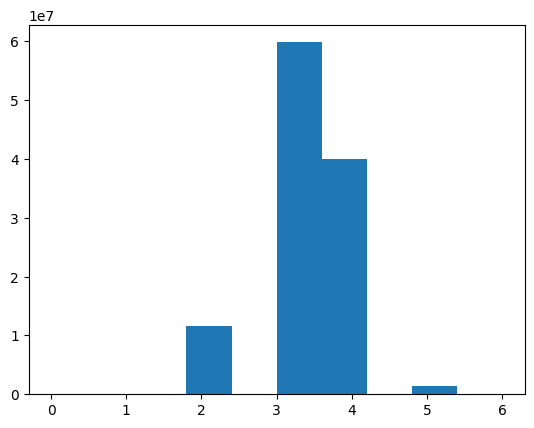

In [30]:
plt.hist(distance_pairs.values())

In [13]:
pos, neg = [], []

for pair, distance in tqdm(distance_pairs.items()):
    if distance == 1:
        pos.append(pair)
    if distance > 1:
        neg.append(pair)

100%|██████████| 112912878/112912878 [00:23<00:00, 4803462.03it/s]


In [14]:
print(f'There are {len(pos):,} positive edges, and {len(neg):,} negative edges')

There are 48,261 positive edges, and 112,849,590 negative edges


In the paper, the authors trained the model with $1:1$ link/non-link ratio, and these ratios for test are $1:1/2/3/4$.

Therefore, we will need $24,130$ positive samples and the same amount in negative samples for training.

For testing, we need $24,130$ positive samples, and $24,130*4=96,520$ negative samples.

In total, we will need $24,130*4=120,650$ negative samples.

In [15]:
POSITIVE_SIZE = 24_130

In [16]:
# Removing the odd element at the end
pos = pos[:POSITIVE_SIZE*2]
len(pos)

48260

In [17]:
neg_subset = neg[::len(neg)//(POSITIVE_SIZE*5)][:POSITIVE_SIZE*5]
len(neg_subset)

120650

According to the paper, each node will be assigned a color using this formula:

$$
f_{l}(i) = 1 + \min(d_x, d_y) + \frac{d}{2} \left[\frac{d}{2} + (d \% 2) - 1 \right]
$$

where *i* is a neighbouring node, *x* and *y* are the pair of nodes under consideration, $d_x$ and $d_y$ are shortest paths between *i* and *x*, *y*, respectively, and $d = d_x + d_y$.

We will now write a function to calculate this color, given *i*, *x* and *y*.


In [18]:
def get_distance(n1, n2):
    n1, n2 = min(n1, n2), max(n1, n2)
    return distance_pairs[(n1, n2)]


def get_color(i, x, y):
    dx, dy = get_distance(i, x), get_distance(i, y)
    d = dx + dy
    color = 1 + min(dx, dy) + d/2 * (d/2 + d%2 - 1)
    
    # in the paper, the authors do not apply this *4 step. 
    # But if not, how will they do the one-hot encoding
    # when the color is a float (e.g. 4.25)?
    return int(color)

We then calculate the color of every 1-hop neighbors for all the positive and negative pairs.

The authors used $64$ as maximum size of the one-hot embedding, and also the size of the subgraph embedding.

In [19]:
MAX_COLOR = 64

In [20]:
# Create adjacency list:
from collections import defaultdict
adj_list = defaultdict(list)

for node1, node2 in edges:
    if node1 not in adj_list[node2]:
        adj_list[node2].append(node1)
    if node2 not in adj_list[node1]:
        adj_list[node1].append(node2)

In [154]:
# def get_pair_colors(pair):
#     node1, node2 = pair

#     subgraph_nodes = set(adj_list[node1] + adj_list[node2])
#     subgraph_nodes.discard(node1)
#     subgraph_nodes.discard(node2)
    
#     colors = set()
#     for subgraph_node in subgraph_nodes:
#         colors.add(get_color(subgraph_node, node1, node2))

#     return colors

# colors = set()
# for pair in tqdm(pos + neg_subset):
#     colors = colors.union(get_pair_colors(pair))

# colors

In [21]:
def process_data_pair(pair):
    node1, node2 = pair

    subgraph_nodes = set(adj_list[node1] + adj_list[node2] + [node1, node2])
    # subgraph_nodes.discard(node1)
    # subgraph_nodes.discard(node2)
    subgraph_nodes_to_idx = {node:i for i, node in enumerate(subgraph_nodes)}

    subgraph_edge_idx = []
    for subgraph_node in subgraph_nodes:
        nbs = adj_list[subgraph_node]
        for nb in nbs:
            # edge = [subgraph_node, nb]
            if (
                # node1 in edge or node2 in edge or # not counting the link containing the target nodes
                nb not in subgraph_nodes
            ): 
                continue
            subgraph_edge_idx.append([
                subgraph_nodes_to_idx[subgraph_node],
                subgraph_nodes_to_idx[nb],
            ])

    subgraph_edge_idx = torch.tensor(subgraph_edge_idx).t()

    one_hot_colors = []
    for subgraph_node in subgraph_nodes:
        color = get_color(subgraph_node, node1, node2)
        one_hot_color = [0] * MAX_COLOR
        one_hot_color[color] = 1
        one_hot_colors.append(one_hot_color)

    return torch.tensor(one_hot_colors), subgraph_edge_idx

Creating the train and test dataset

In [22]:
def create_data_from_node_pairs(pairs, labels):
    dataset = []
    for pair, label in tqdm(zip(pairs, labels)):
        subgraph_node_features, subgraph_edge_idx = process_data_pair(pair)
        data = Data(
            x=subgraph_node_features, 
            edge_index=subgraph_edge_idx,
            y=torch.tensor([label])
        )
        dataset.append(data)
    return dataset

In [29]:
train_dataset = create_data_from_node_pairs(
    pairs=pos[:POSITIVE_SIZE] + neg_subset[:POSITIVE_SIZE],
    labels=[1.0]*POSITIVE_SIZE + [0.0]*POSITIVE_SIZE
)
torch.save(train_dataset, '../data/train_dataset.pt')

48260it [00:36, 1330.32it/s]


In [42]:
test_dataset_1_1 = create_data_from_node_pairs(
    pairs=pos[POSITIVE_SIZE:] + neg_subset[POSITIVE_SIZE:POSITIVE_SIZE*2],
    labels=[1.0]*POSITIVE_SIZE + [0.0]*POSITIVE_SIZE
)
# torch.save(test_dataset_1_1, '../data/test_dataset_1_1.pt')

test_dataset_1_2 = test_dataset_1_1 + create_data_from_node_pairs(
    pairs=neg_subset[POSITIVE_SIZE*2:POSITIVE_SIZE*3],
    labels=[0.0]*POSITIVE_SIZE
)
# torch.save(test_dataset_1_2, '../data/test_dataset_1_2.pt')

test_dataset_1_3 = test_dataset_1_2 + create_data_from_node_pairs(
    pairs=neg_subset[POSITIVE_SIZE*3:POSITIVE_SIZE*4],
    labels=[0.0]*POSITIVE_SIZE
)
# torch.save(test_dataset_1_3, '../data/test_dataset_1_3.pt')

test_dataset_1_4 = test_dataset_1_3 + create_data_from_node_pairs(
    pairs=neg_subset[POSITIVE_SIZE*4:],
    labels=[0.0]*POSITIVE_SIZE
)
# torch.save(test_dataset_1_4, '../data/test_dataset_1_4.pt')

24130it [00:16, 1491.84it/s]
24130it [00:15, 1514.81it/s]
24130it [00:16, 1507.55it/s]


In [ ]:
# train_dataset = torch.load('../data/train_dataset.pt')
# test_dataset_1_1 = torch.load('../data/test_dataset_1_1.pt')
# test_dataset_1_2 = torch.load('../data/test_dataset_1_2.pt')
# test_dataset_1_3 = torch.load('../data/test_dataset_1_3.pt')
# test_dataset_1_4 = torch.load('../data/test_dataset_1_4.pt')

# Model training

The model is defined as a 3-layer GCN. The input dim , hidden size, and output dim of each layer is equal to the one-hot embedding size.

The original paper from Kipf and Welling (2017) used ReLU activation, but in this paper the authors used sigmoid instead.

In [24]:
class GNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.conv3 = GCNConv(hidden_dim, output_dim)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = F.sigmoid(x)
        
        x = self.conv2(x, edge_index)
        x = F.sigmoid(x)

        x = self.conv3(x, edge_index)
        x = F.sigmoid(x)

        x = global_mean_pool(x, batch)

        return x

class BinaryClassifier(torch.nn.Module):
    def __init__(self, input_dim):
        super(BinaryClassifier, self).__init__()
        self.fc = torch.nn.Linear(input_dim, 1)

    def forward(self, x):
        x = self.fc(x)
        return x

class CombinedModel(torch.nn.Module):
    def __init__(self, gnn_input_dim, gnn_hidden_dim, gnn_output_dim):
        super(CombinedModel, self).__init__()
        self.gnn = GNN(gnn_input_dim, gnn_hidden_dim, gnn_output_dim)
        self.classifier = BinaryClassifier(gnn_output_dim)

    def forward(self, x, edge_index, batch):
        subgraph_embedding = self.gnn(x, edge_index, batch)
        output = self.classifier(subgraph_embedding)

        return output

In [25]:
model = CombinedModel(gnn_input_dim=MAX_COLOR, gnn_hidden_dim=MAX_COLOR, gnn_output_dim=MAX_COLOR)

Let's just start making inference without any training and see how good it can be.

In [26]:
test_dataloader_1_1 = DataLoader(test_dataset_1_1, batch_size=128)

In [ ]:
all_labels = []
all_probs = []

with torch.no_grad():
    for batch in test_dataloader_1_1:
        logits = model(batch.x.float(), batch.edge_index.int(), batch.batch)
        probs = torch.sigmoid(logits).squeeze()

        all_labels.append(batch.y.float())
        all_probs.append(probs)

all_labels = torch.cat(all_labels)
all_probs = torch.cat(all_probs)

auc_score = roc_auc_score(all_labels, all_probs)
print(f"AUC Score: {auc_score:.4f}")

AUC Score: 0.8430


AUC = 0.843 for no training at all seems quite high. Let's see how much it improves with training.

We will now start training to see how much it improves

In [30]:
# Training setup
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
model.train()
epochs = 20

In [186]:
# Get a single batch from the train_dataloader
for batch in train_dataloader:
    print("Node features (x):", batch.x)
    print("Edge index:", batch.edge_index)
    print("Batch vector:", batch.batch)
    print("Labels (y):", batch.y)
    print('========')
    print("Node features (x) shape:", batch.x.shape)
    print("Edge index shape:", batch.edge_index.shape)
    print("Batch vector shape:", batch.batch.shape)
    print("Labels (y) shape:", batch.y.shape)
    break

Node features (x): tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])
Edge index: tensor([[1.0000e+00, 2.0000e+00, 3.0000e+00,  ..., 1.0940e+03, 1.0950e+03,
         1.0960e+03],
        [2.0000e+00, 1.0000e+00, 5.0000e+00,  ..., 1.0890e+03, 1.0960e+03,
         1.0950e+03]])
Batch vector: tensor([  0,   0,   0,  ..., 126, 127, 127])
Labels (y): tensor([0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1.,
        0., 1., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 1.,
        0., 0., 1., 1., 0., 1., 0., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 0.,
        0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1.,
        1., 1., 1., 0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 1., 1., 1., 1., 1.,
     

In [31]:
for epoch in range(epochs):
    total_loss = 0
    for batch in train_dataloader:
        optimizer.zero_grad()

        output = model(batch.x.float(), batch.edge_index.int(), batch.batch)

        loss = criterion(output, batch.y.float().unsqueeze(-1))

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f'Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(train_dataloader)}')

Epoch 1/20, Loss: 0.2509524576346237
Epoch 2/20, Loss: 0.17543786351209278
Epoch 3/20, Loss: 0.17319882885804253
Epoch 4/20, Loss: 0.17302369162755668
Epoch 5/20, Loss: 0.1705150519492765
Epoch 6/20, Loss: 0.17082862475167507
Epoch 7/20, Loss: 0.16884724350360336
Epoch 8/20, Loss: 0.1681342276710051
Epoch 9/20, Loss: 0.16745123185375066
Epoch 10/20, Loss: 0.16853190986094652
Epoch 11/20, Loss: 0.16885086915716924
Epoch 12/20, Loss: 0.16852396752231966
Epoch 13/20, Loss: 0.16701751909952947
Epoch 14/20, Loss: 0.16662541713821824
Epoch 15/20, Loss: 0.16570828735788978
Epoch 16/20, Loss: 0.16700614091974716
Epoch 17/20, Loss: 0.1667262596132421
Epoch 18/20, Loss: 0.166540174976622
Epoch 19/20, Loss: 0.16979414476919427
Epoch 20/20, Loss: 0.16601103854183324


In [ ]:
torch.save(model, '../data/model.pt')

# Evaluating on test datasets

### 1:1 link/non-link ratio

In [32]:
all_labels = []
all_probs = []

with torch.no_grad():
    for batch in test_dataloader_1_1:
        logits = model(batch.x.float(), batch.edge_index.int(), batch.batch)
        probs = torch.sigmoid(logits).squeeze()

        all_labels.append(batch.y.float())
        all_probs.append(probs)

all_labels = torch.cat(all_labels)
all_probs = torch.cat(all_probs)

auc_score = roc_auc_score(all_labels, all_probs)
print(f"AUC Score: {auc_score:.4f}")

AUC Score: 0.9810


Let's now plot the predicted probability. The first half of the test data has label 1, and the second half has label 0.

Since the number of data will be big, we will plot one data point after every 200 data points.

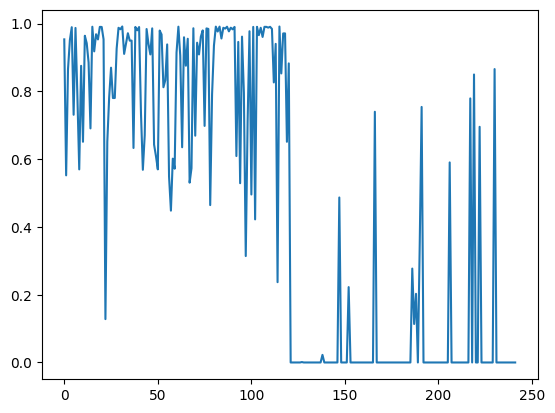

In [40]:
plt.plot(all_probs[::200])